# Visualize the MS-SMC' likelihood surface
Here we compute the likelihood of an ARG dataset across a grid of demographic model parameters to visualize the likelihood surface.

In [4]:
from pathlib import Path
import toytree
import ipcoal
import pandas as pd
import numpy as np
from scipy import stats

In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams['figure.figsize'] = [4, 3]

In [6]:
from numba import set_num_threads
set_num_threads(30)

In [7]:
print(toytree.__version__)
print(ipcoal.__version__)

3.0.6
0.4.dev6


### Set output directory for result figures

In [9]:
DIR = Path("../manuscript/figures/likelihood-heatmaps")
DIR.mkdir(exist_ok=True)

## Parameters

In [11]:
RECOMB = 2e-9
SEED = 123
NEFFS = np.array([2e5, 3e5, 4e5])
ROOT_HEIGHT = 1e6
NSPECIES = 2
NSAMPLES = 4

NSITES = 4e5
NLOCI = 50

### GRID
These are the ranges of parameters over which we will examine the likelihood surface.

In [12]:
NEFF_MIN = 5e4
R_MIN = 1e-9
NEFF_MAX = 9.5e5
R_MAX = 3e-9
N_VALUES = 31

## Simulate ARGs on a 2-population model

In [13]:
sptree = toytree.rtree.imbtree(NSPECIES, treeheight=ROOT_HEIGHT)
sptree = sptree.set_node_data("Ne", NEFFS)

In [14]:
# get a parameterized ipcoal Model
model = ipcoal.Model(
    sptree,
    nsamples=NSAMPLES,
    recomb=RECOMB,
    seed_trees=SEED,
    discrete_genome=False,
    record_full_arg=True,
    ancestry_model="hudson",
)

In [15]:
# get mapping of samples to species
imap = model.get_imap_dict()

### Get trees and interval lengths from tree sequences

In [16]:
# data to fill
trees_r = []
trees_g = []
trees_t = []
dists_r = []
dists_g = []
dists_t = []
events = []

# iterate over each tree sequence
for lidx in range(NLOCI):
    
    # get full tree sequence and store first tree
    ts = next(model._get_tree_sequence_generator(nsites=NSITES))
    tree = ts.first(sample_lists=True)
    
    # get a simplified tree sequence and store first simplified tree
    sts = ts.simplify(filter_sites=False)
    stree = sts.at(tree.interval.left, sample_lists=True)
    last_tree = stree.copy()
    last_topo = stree.copy()
    
    # distance counters start w/ length of first interval
    sum_tree_dist = tree.get_length()
    sum_topo_dist = tree.get_length()
    
    # store first tree
    trees_r.append(stree.copy())
    dists_r.append(tree.get_length())
        
    # advance to next tree in the full tree sequence
    while tree.next():
   
        # get simple tree in next interval (at tree's position in sts)
        stree = sts.at(tree.interval.left, sample_lists=True)
        
        # store this event
        trees_r.append(stree.copy())
        dists_r.append(tree.get_length())
        
        # if tree changed
        if stree.kc_distance(last_tree, lambda_=1):
            
            # if topology changed
            if stree.kc_distance(last_topo, lambda_=0):
                trees_t.append(last_topo.copy())
                dists_t.append(sum_topo_dist)
                trees_g.append(last_tree.copy())
                dists_g.append(sum_tree_dist)
                last_topo = stree.copy()
                last_tree = stree.copy()
                events.append(2)
                sum_tree_dist = tree.get_length()
                sum_topo_dist = tree.get_length()
                
            # only branch length changed
            else:
                trees_g.append(last_tree.copy())
                dists_g.append(sum_tree_dist)
                last_tree = stree.copy()
                events.append(1)
                sum_tree_dist = tree.get_length()
                sum_topo_dist += tree.get_length()

        # no change occured
        else:
            events.append(0)
            sum_tree_dist += tree.get_length()
            sum_topo_dist += tree.get_length()

# convert interval lengths to arrays
dists_r = np.array(dists_r)
dists_g = np.array(dists_g)
dists_t = np.array(dists_t)
events = np.array(events)

# convert all tskit trees to ToyTrees
trees_r = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_r]
trees_g = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_g]
trees_t = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_t]

### Save trees and interval length data to disk

In [17]:
# Not necessary, generating them by simulation above is fast enough.

### Summarize simulated ARG and recomb event types

In [18]:
print(f"{len(trees_r)} R (recomb) intervals w/ average length={dists_r.mean():.2f}")
print(f"{len(trees_g)} G (tree-change) intervals w/ average length={dists_g.mean():.2f}")
print(f"{len(trees_t)} T (topo-change) intervals w/ average length={dists_t.mean():.2f}")

235872 R (recomb) intervals w/ average length=84.79
160501 G (tree-change) intervals w/ average length=124.56
59288 T (topo-change) intervals w/ average length=336.93


In [19]:
# multitree drawing kwargs
kwargs = dict(
    shape=(1, 6), 
    width=1000, 
    height=300,
    edge_type='p',
    layout='d',
    fixed_order=trees_r[0].get_tip_labels(), 
    shared_axes=True, 
    scale_bar=True, 
)

In [20]:
# trees between any recomb event [r]
print(dists_r[:6].round(2))
toytree.mtree(trees_r[:6]).draw(**kwargs);

[172.13 110.42  82.36  24.66  92.36 173.71]


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="300.0px" viewBox="0 0 1000.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc91c15c18a8445cd9bacb2194f9a606d"> r1_0 r1_3 r1_1 r1_2 r0_0 r0_2 r0_1 r0_3 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_0 r1_3 r1_1 r1_2 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_3 r1_0 r1_1 r1_2 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_2 r1_3 r1_0 r1_1 0 500000 1000000 r1_3 r0_0 r0_2 r0_1 r0_3 r1_2 r1_0 r1_1 0 500000 1000000 r1_3 r1_2 r1_0 r1_1 r0_0 r0_2 r0_1 r0_3 0 500000 1000000

In [21]:
# trees between tree-change events [g]
print(dists_g[:6].round(2))
toytree.mtree(trees_g[:8]).draw(**kwargs);

[172.13 110.42  82.36  24.66  92.36 173.71]


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="300.0px" viewBox="0 0 1000.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t774fe106753a4aa7839d90580d5f0c3d"> r1_0 r1_3 r1_1 r1_2 r0_0 r0_2 r0_1 r0_3 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_0 r1_3 r1_1 r1_2 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_3 r1_0 r1_1 r1_2 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_2 r1_3 r1_0 r1_1 0 500000 1000000 r1_3 r0_0 r0_2 r0_1 r0_3 r1_2 r1_0 r1_1 0 500000 1000000 r1_3 r1_2 r1_0 r1_1 r0_0 r0_2 r0_1 r0_3 0 500000 1000000

In [22]:
# trees between topo-change events [t]
print(dists_t[:6].round(2))
toytree.mtree(trees_t[:8]).draw(**kwargs);

[172.13 110.42  82.36  24.66  92.36 173.71]


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="300.0px" viewBox="0 0 1000.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t49a114017ca54fb189076e65df0bf523"> r1_0 r1_3 r1_1 r1_2 r0_0 r0_2 r0_1 r0_3 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_0 r1_3 r1_1 r1_2 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_3 r1_0 r1_1 r1_2 0 500000 1000000 r0_0 r0_2 r0_1 r0_3 r1_2 r1_3 r1_0 r1_1 0 500000 1000000 r1_3 r0_0 r0_2 r0_1 r0_3 r1_2 r1_0 r1_1 0 500000 1000000 r1_3 r1_2 r1_0 r1_1 r0_0 r0_2 r0_1 r0_3 0 500000 1000000

### Get embedding tables
These are functions from ipcoal for fast likelihood calculations

In [23]:
R = ipcoal.smc.TreeEmbedding(model.tree, trees_r, imap, nproc=20)

In [24]:
G = ipcoal.smc.TreeEmbedding(model.tree, trees_g, imap, nproc=20)

In [25]:
T = ipcoal.smc.TreeEmbedding(model.tree, trees_t, imap, nproc=20)

### Test likelihood methods

#### SMC

In [26]:
ipcoal.smc.get_ms_smc_loglik_from_embedding(R, RECOMB, dists_r, event_type=0)

1271243.3938515333

In [27]:
ipcoal.smc.get_ms_smc_loglik_from_embedding(G, RECOMB, dists_g, event_type=1)

927981.7663029598

In [28]:
ipcoal.smc.get_ms_smc_loglik_from_embedding(T, RECOMB, dists_t, event_type=2)

397214.84807981463

#### MSC

In [29]:
ipcoal.msc.get_msc_loglik_from_embedding(R.emb)

23621482.605138663

In [30]:
ipcoal.msc.get_msc_loglik_from_embedding(G.emb)

16076466.653329838

In [31]:
ipcoal.msc.get_msc_loglik_from_embedding(T.emb)

5968036.811625589

### Plotting functions

In [32]:
def get_smc_likelihood_surface_Nx_r(
    embedding: ipcoal.smc.TreeEmbedding,
    lengths: np.ndarray,
    event_type: int,
    nidx: int = 0,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int = 21,
):
    """Return an array of log likelihood scores over a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos, indexing="ij")
    Z = np.zeros(X.shape)

    for i, n0 in enumerate(neffs):
        params = NEFFS.copy()
        params[nidx] = n0
        embedding._update_neffs(params)
        for j, rec in enumerate(recos):
            Z[i, j] = ipcoal.smc.get_ms_smc_loglik_from_embedding(embedding, rec, lengths, event_type=event_type)
    return X, Y, Z

In [33]:
def get_msc_likelihood_surface_Nx_r(
    embedding: ipcoal.smc.TreeEmbedding,
    nidx: int = 0,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos, indexing="ij")
    Z = np.zeros(X.shape)

    for i, n0 in enumerate(neffs):

        params = NEFFS.copy()
        params[nidx] = n0
        embedding._update_neffs(params)

        # get expon rate parameter for each embedded genealogy
        Z[i, :] = ipcoal.msc.get_msc_loglik_from_embedding(embedding.emb)
            
    return X, Y, Z

In [34]:
def get_smc_likelihood_surface_Nx_Ny(
    embedding: ipcoal.smc.TreeEmbedding,
    lengths: np.ndarray,
    event_type: int,
    nidx: int = 0,
    nidy: int = 1,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs0 = np.linspace(min_neff, max_neff, n_values)
    neffs1 = np.linspace(min_neff, max_neff, n_values)
    X, Y = np.meshgrid(neffs0, neffs1, indexing="ij")
    Z = np.zeros(X.shape)
       
    for i, n0 in enumerate(neffs0):
        for j, n1 in enumerate(neffs1):
            
            # update the embedding table with 2Ne
            params = NEFFS.copy()
            params[nidx] = n0
            params[nidy] = n1
            embedding._update_neffs(params)

            # get expon rate parameter for each embedded genealogy
            Z[i, j] = ipcoal.smc.get_ms_smc_loglik_from_embedding(embedding, RECOMB, lengths, event_type=event_type)
    return X, Y, Z

In [35]:
def get_msc_likelihood_surface_Nx_Ny(
    embedding: ipcoal.smc.TreeEmbedding,
    nidx: int = 0,
    nidy: int = 1,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    """
    neffs0 = np.linspace(min_neff, max_neff, n_values)
    neffs1 = np.linspace(min_neff, max_neff, n_values)
    X, Y = np.meshgrid(neffs0, neffs1, indexing="ij")
    Z = np.zeros(X.shape)
       
    for i, n0 in enumerate(neffs0):
        for j, n1 in enumerate(neffs1):
            
            params = NEFFS.copy()
            params[nidx] = n0
            params[nidy] = n1
            embedding._update_neffs(params)

            # get expon rate parameter for each embedded genealogy
            Z[i, j] = ipcoal.msc.get_msc_loglik_from_embedding(embedding.emb)

    return X, Y, Z

### Plotting function 1

In [36]:
def plot_likelihood_surface_Nx_Ny(x, y, z, nidx=0, nidy=1, levels=15, title="", vmin=None):
    # setup axes
    fig, ax = plt.subplots()
    
    # clip to top 10% to concentrate gradient visualization
    zr = z.max() - z.min()
    zv = np.clip(z, z.min(), z.max() - (zr * 0.90))
    zv -= zv.min()

    # draw contour plot and mark X at true value
    cs = ax.contourf(
        x, y, zv, 
        levels=levels, cmap='viridis_r', linestyles='solid', 
    )
    ma = ax.scatter(
        NEFFS[nidx], NEFFS[nidy], 
        marker="x", s=90, linewidth=5, c="white",
    )
    ma = ax.scatter(
        NEFFS[nidx], NEFFS[nidy], 
        marker="x", s=75, linewidth=2, c="black",
    )
    
    # add a colorbar
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel(f"$\\Delta$ log likelihood", fontsize=12)
    if z.min() == z.max():
        cbar.locator = ticker.NullLocator()
    cbar.formatter.set_useMathText(True)
    cbar.formatter.set_powerlimits((3, 3))  # Example: forces scientific notation at 10^3
    cbar.update_ticks()

    # style xy axes
    ax.set_xlabel(f'Diploid N$_e${nidx}', fontsize=18)
    ax.set_ylabel(f'Diploid N$_e${nidy}', fontsize=18);
    ax.set_xticks([200_000, 400_000, 600_000, 800_000])
    ax.set_yticks([200_000, 400_000, 600_000, 800_000])
    ax.tick_params(labelsize=14, width=2, length=6)
    ax.set_title(title, fontsize=16, pad=15)
    ax.ticklabel_format(scilimits=(3, 3), useMathText=True)
    return fig, ax, (cs, ma, cbar)

#### Testing

In [37]:
# nx, ny = 0, 1
# c, a, m = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'g')], nidx=nx, nidy=ny, levels=15, title='test');

### Plotting function 2

In [38]:
def plot_likelihood_surface_r_Nx(x, y, z, nidx=0, levels=15, title="", vmin=None):
    # setup axes
    fig, ax = plt.subplots()

    # clip to top 10% to concentrate gradient visualization
    zr = z.max() - z.min()
    zv = np.clip(z, z.min(), z.max() - (zr * 0.90))
    zv -= zv.min()
    
    # contour and x marks
    cs = ax.contourf(x, y, zv, levels=levels, cmap='viridis_r', vmin=vmin, linestyles='solid')
    #ma = ax.scatter(NEFFS[nidx], RECOMB, marker="x", s=75, linewidth=2, color="black")
    ma = ax.scatter(
        NEFFS[nidx], RECOMB,
        marker="x", s=90, linewidth=5, c="white",
    )
    ma = ax.scatter(
        NEFFS[nidx], RECOMB, 
        marker="x", s=75, linewidth=2, c="black",
    )
    # colorbar
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel("$\\Delta$ log likelihood", fontsize=12)
    cbar.formatter.set_powerlimits((3, 3))
    cbar.formatter.set_useMathText(True)
    cbar.update_ticks()

    # style xy axes
    ax.set_xlabel(f'Diploid N$_e${nidx}', fontsize=16);
    ax.set_xticks([200_000, 400_000, 600_000, 800_000])
    ax.set_ylabel('Recombination rate', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_title(title, fontsize=16, pad=15)
    ax.ticklabel_format(axis='x', scilimits=(3, 3))
    return fig, ax, (cs, ma, cbar)

#### testing

In [39]:
# c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(1, 'r', 'r')], nidx=1, title="X");

### PLOT GRIDS
We will fill these dicts with likelihood values below.

In [40]:
MSC = {}
SMC = {}

#### MSC fit (Ne_x, Ne_y) using tree-change or topo-change trees

As expected, the plots below show that species tree parameters (Ne values) can be accurately estimated from coalescent waiting times in genealogies. The species intervals at the tips are more precisely estimated than at internal nodes, and the datasets with more trees (e.g., R versus T) provide more precise estimates.

In [41]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    MSC_N_R = get_msc_likelihood_surface_Nx_Ny(
        R,
        nx, ny,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    MSC_N_G = get_msc_likelihood_surface_Nx_Ny(
        G,
        nx, ny,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )

    MSC_N_T = get_msc_likelihood_surface_Nx_Ny(
        T,
        nx, ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    MSC[(nx, ny, 'r')] = MSC_N_R
    MSC[(nx, ny, 'g')] = MSC_N_G
    MSC[(nx, ny, 't')] = MSC_N_T
    MSC[(nx, ny, 'gt')] = MSC_N_G[0], MSC_N_G[1], MSC_N_G[2] + MSC_N_T[2]
    MSC[(nx, ny, 'rgt')] = MSC_N_G[0], MSC_N_G[1], MSC_N_R[2] + MSC_N_G[2] + MSC_N_T[2]

NOTE: These are the MSC results when genealogies are perfectly delimited.

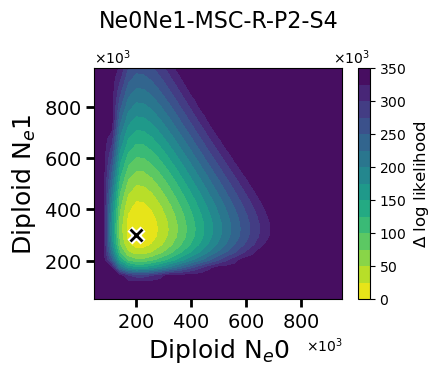

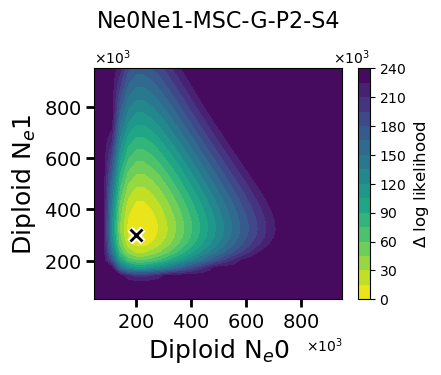

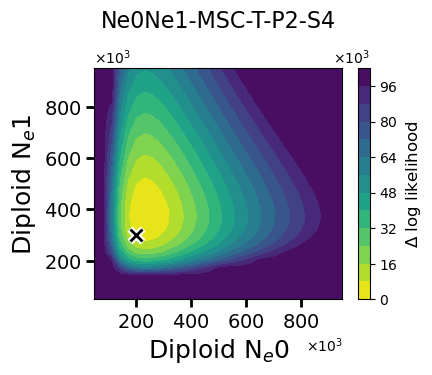

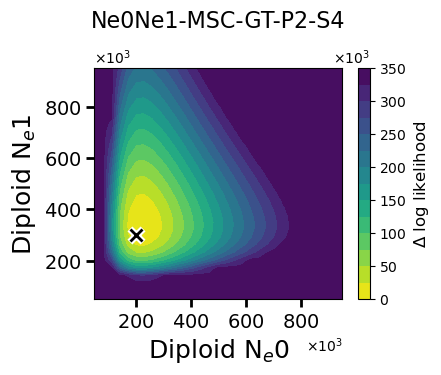

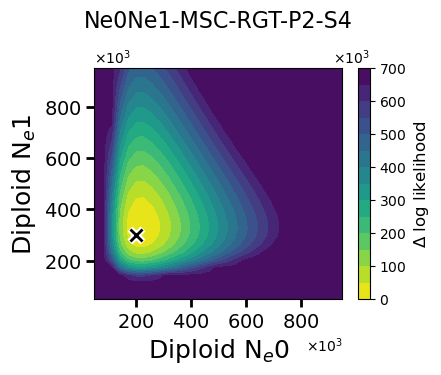

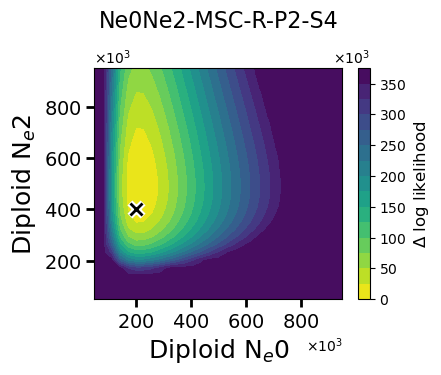

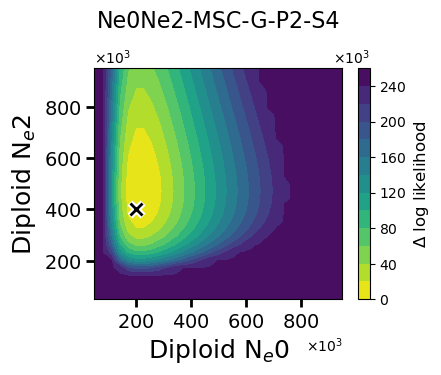

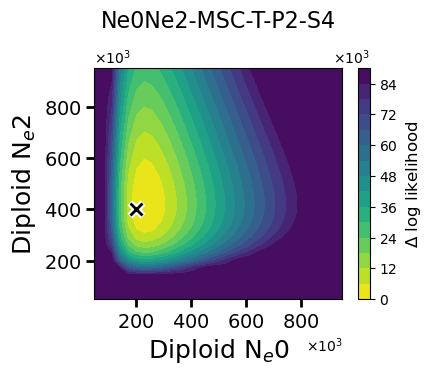

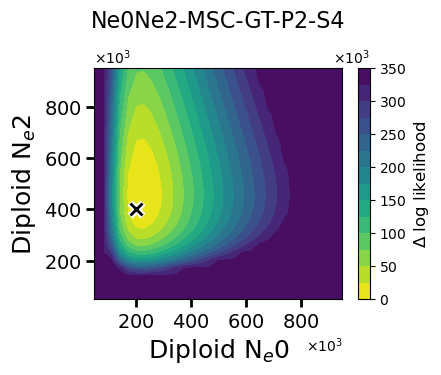

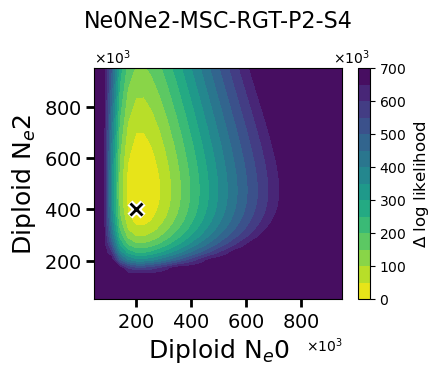

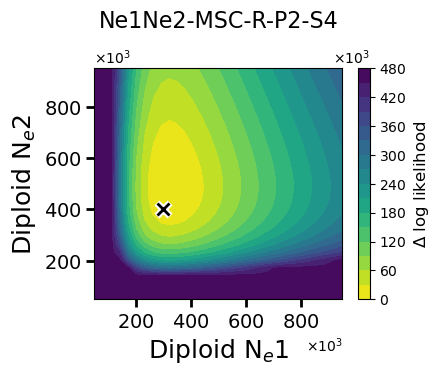

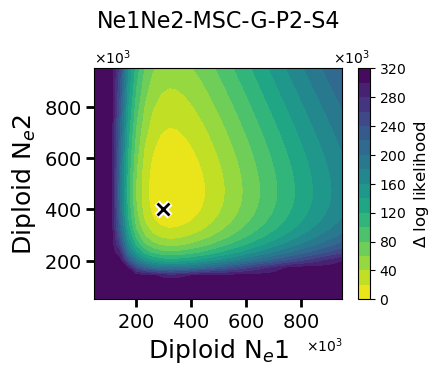

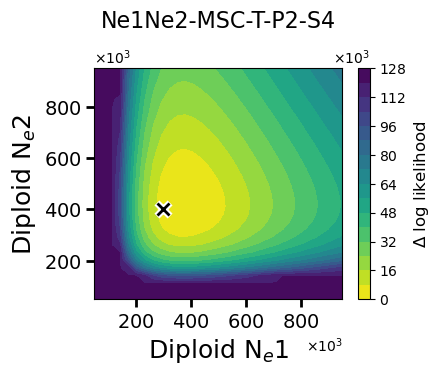

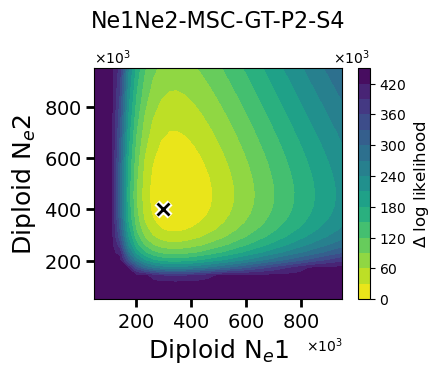

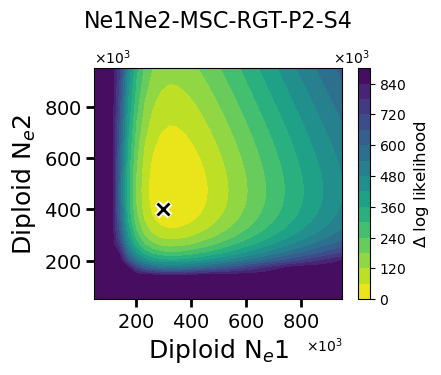

In [42]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    # plot it
    title = f"Ne{nx}Ne{ny}-MSC-R-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'r')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-G-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'g')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-T-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 't')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}Ne{ny}-MSC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'gt')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'rgt')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### MSC fit (r, Ne0) using tree-change or topo-change trees

As expected, the MSC is highly informative about the species tree parameters (Ne values) but not at all informative about the spatial distance parameter (recombination rate).

In [43]:
for nx in range(sptree.nnodes):

    MSC_r_R = get_msc_likelihood_surface_Nx_r(
        R,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    MSC_r_G = get_msc_likelihood_surface_Nx_r(
        G,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )

    MSC_r_T = get_msc_likelihood_surface_Nx_r(
        T,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    MSC[(nx, 'r', 'r')] = MSC_r_R
    MSC[(nx, 'r', 'g')] = MSC_r_G
    MSC[(nx, 'r', 't')] = MSC_r_T
    MSC[(nx, 'r', 'gt')] = MSC_r_G[0], MSC_r_G[1], MSC_r_G[2] + MSC_r_T[2]
    MSC[(nx, 'r', 'rgt')] = MSC_r_G[0], MSC_r_G[1], MSC_r_R[2] + MSC_r_G[2] + MSC_r_T[2]

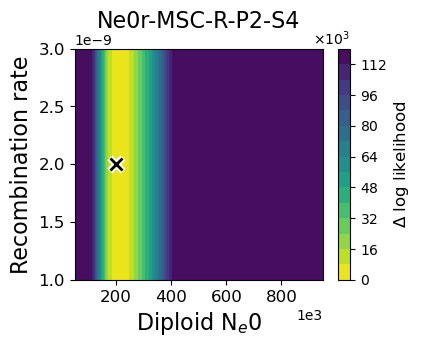

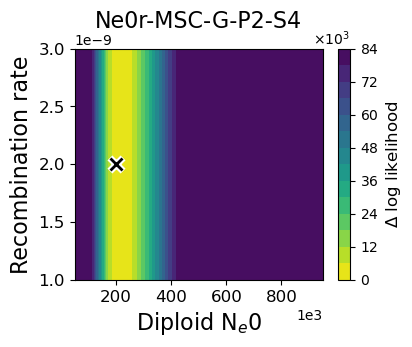

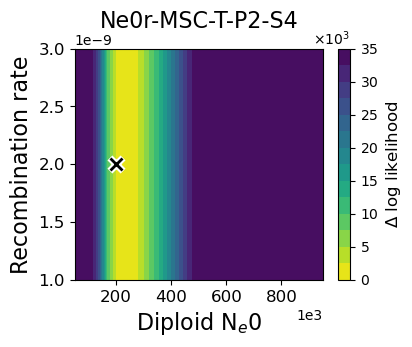

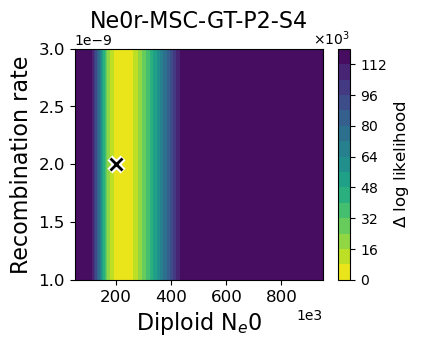

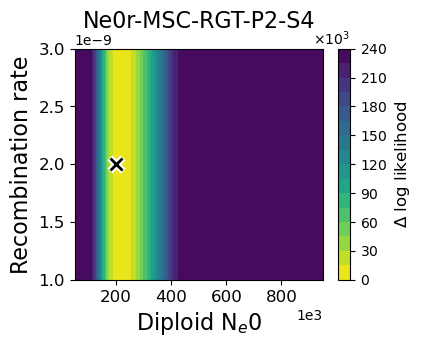

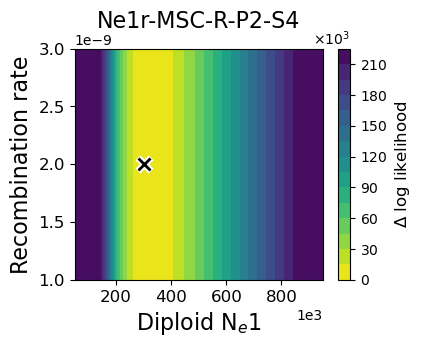

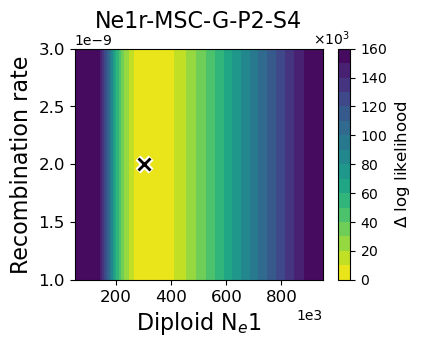

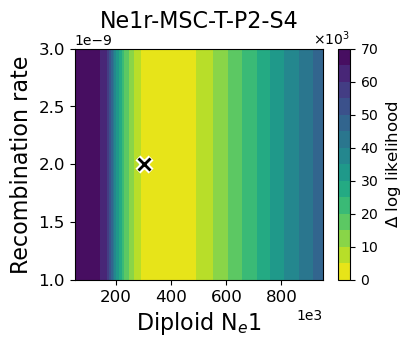

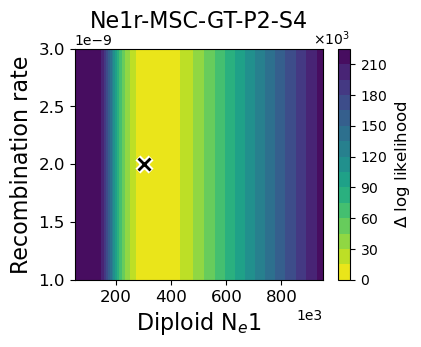

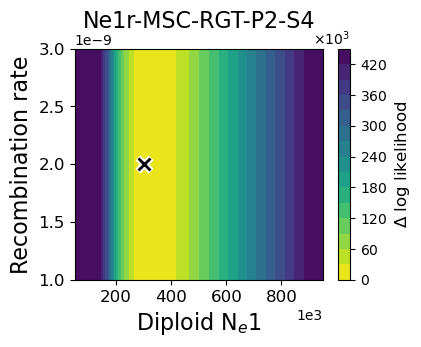

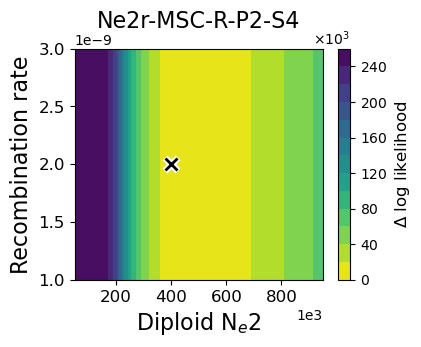

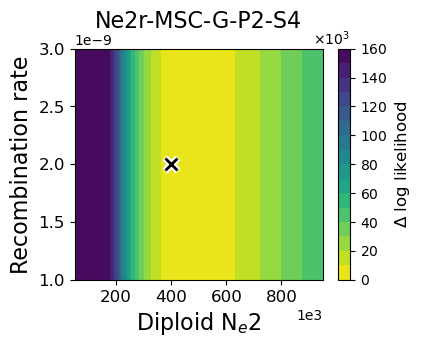

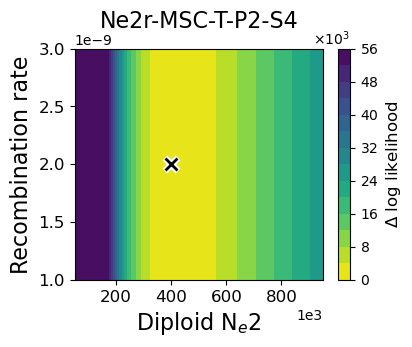

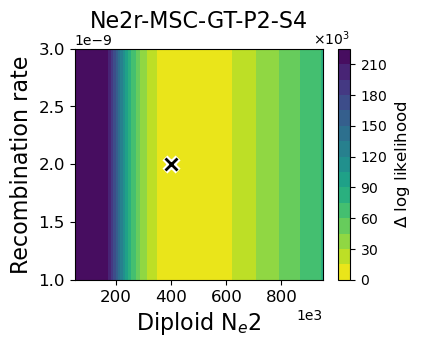

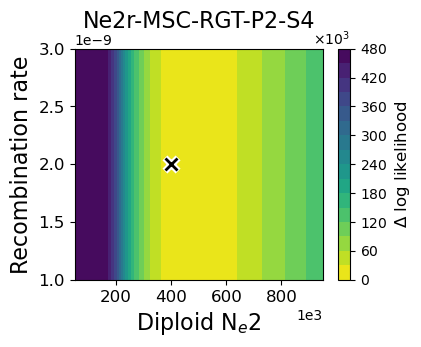

In [44]:
for nx in range(sptree.nnodes):
    # plot it
    title = f"Ne{nx}r-MSC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'r')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-MSC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'g')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-MSC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 't')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}r-MSC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}r-MSC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'rgt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### SMC fit (Ne0, Ne1) using tree-change or topo-change trees and lengths

**Here is where the major breakthrough comes**. In the case of the standard ARG likelihood the waiting distances between recombination events provide **no** information about species tre parameters. By contrast, when using tree-change or topo-change datasets we can see that waiting distances provide substantial information for estimating species tree parameters.

In [45]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    SMC_N_R = get_smc_likelihood_surface_Nx_Ny(
        R,
        dists_r,
        event_type=0,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    SMC_N_G = get_smc_likelihood_surface_Nx_Ny(
        G,
        dists_g,
        event_type=1,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )

    SMC_N_T = get_smc_likelihood_surface_Nx_Ny(
        T,
        dists_t,
        event_type=2,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    SMC[(nx, ny, 'r')] = SMC_N_R  
    SMC[(nx, ny, 'g')] = SMC_N_G
    SMC[(nx, ny, 't')] = SMC_N_T
    SMC[(nx, ny, 'gt')] = SMC_N_G[0], SMC_N_G[1], SMC_N_G[2] + SMC_N_T[2]
    SMC[(nx, ny, 'rgt')] = SMC_N_G[0], SMC_N_G[1], SMC_N_R[2] + SMC_N_G[2] + SMC_N_T[2]
    

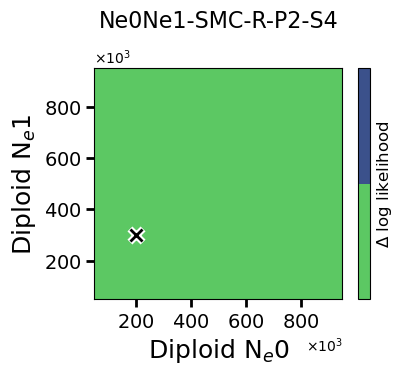

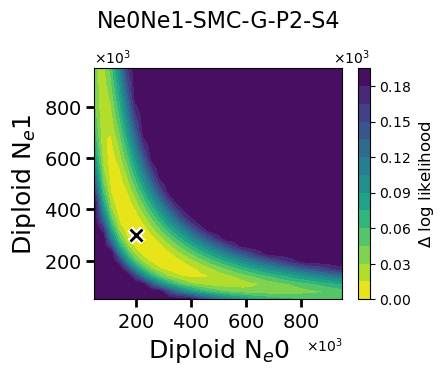

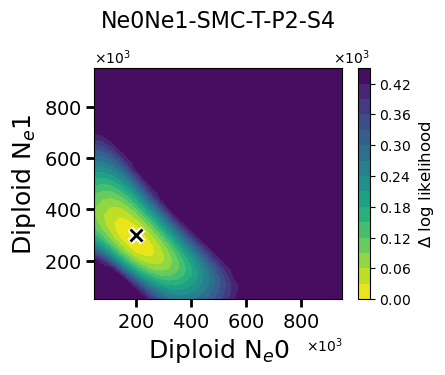

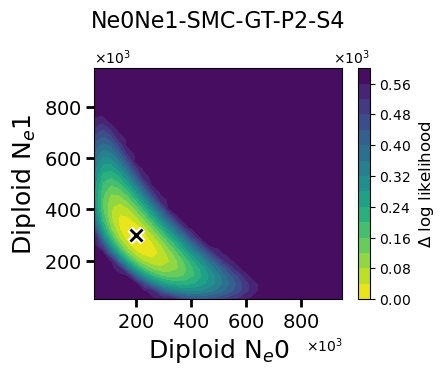

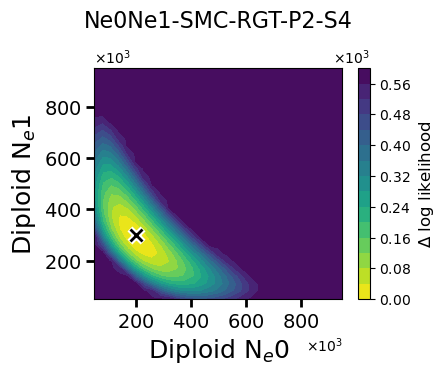

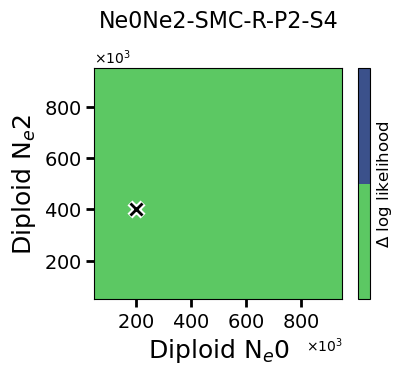

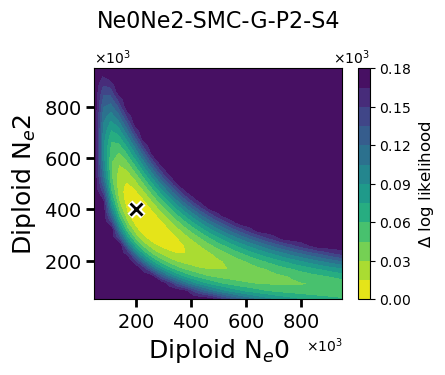

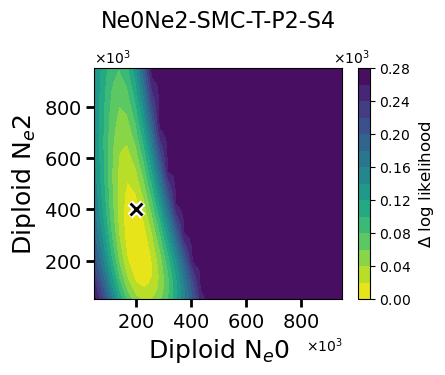

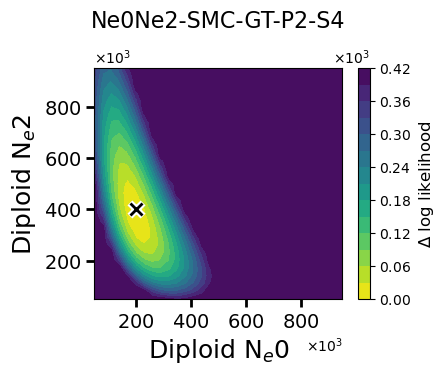

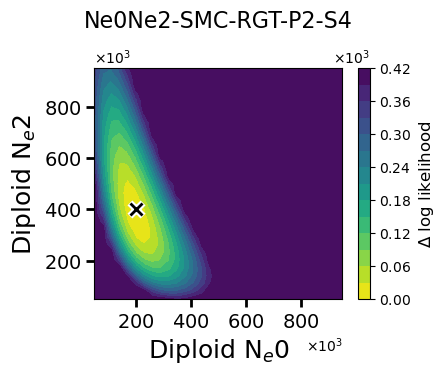

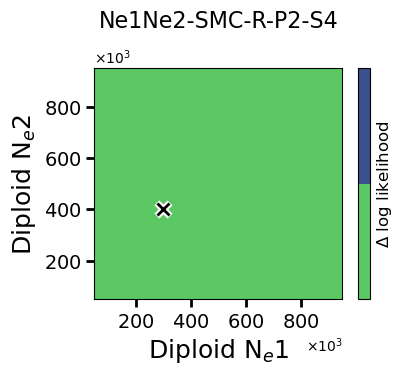

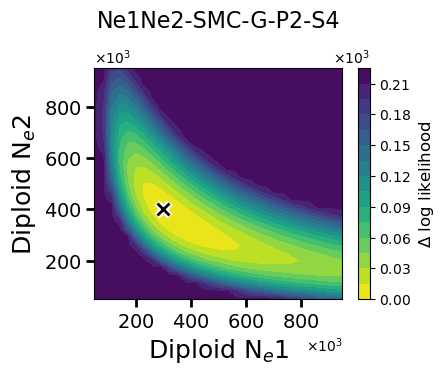

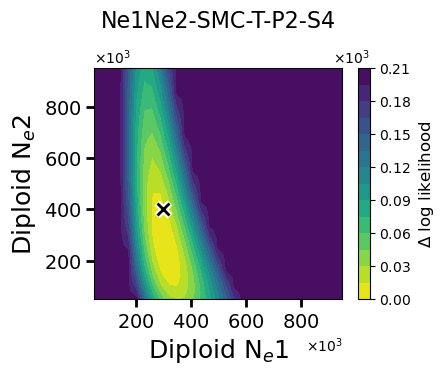

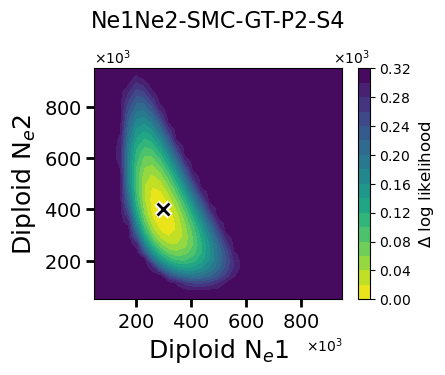

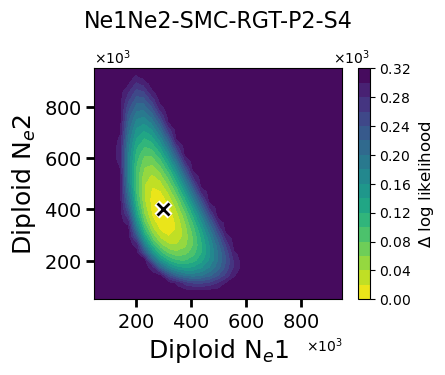

In [46]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    # plot it    
    title = f"Ne{nx}Ne{ny}-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'r')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'g')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 't')], nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'gt')], nidx=nx, nidy=ny, title=title)
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'rgt')], nidx=nx, nidy=ny, title=title)
    c.savefig((DIR / title).with_suffix('.svg'))

#### SMC fit (r, Ne0) using tree-change or topo-change trees and lengths

Similarly, while waiting distances between any events are informative for estimating recombination rate, here we show that we can also estimate recombination rate accurately from tree or topology change waiting distances. This is a great breakthrough because these events are much easier to observe! In addition, they show a slight relationship with species tree parameters, further increasing the power for inference.

In [47]:
for nx in range(sptree.nnodes):

    SMC_r_R = get_smc_likelihood_surface_Nx_r(
        R,
        dists_r,
        event_type=0,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    SMC_r_G = get_smc_likelihood_surface_Nx_r(
        G,
        dists_g,
        event_type=1,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )

    SMC_r_T = get_smc_likelihood_surface_Nx_r(
        T,
        dists_t,
        event_type=2,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    SMC[(nx, 'r', 'r')] = SMC_r_R
    SMC[(nx, 'r', 'g')] = SMC_r_G
    SMC[(nx, 'r', 't')] = SMC_r_T
    SMC[(nx, 'r', 'gt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_G[2] + SMC_r_T[2]
    SMC[(nx, 'r', 'rgt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_R[2] + SMC_r_G[2] + SMC_r_T[2]

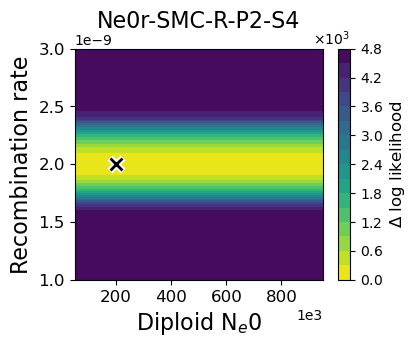

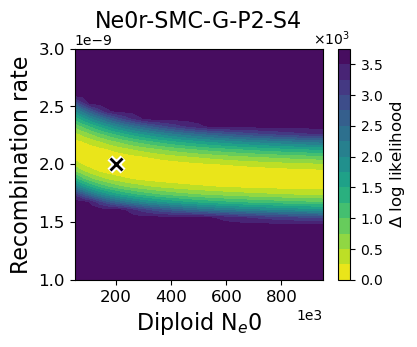

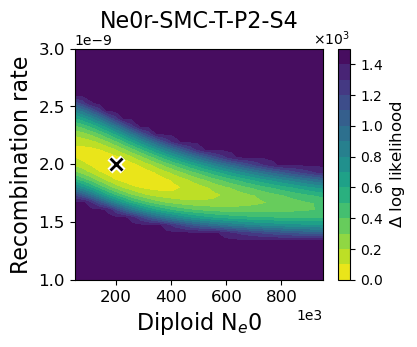

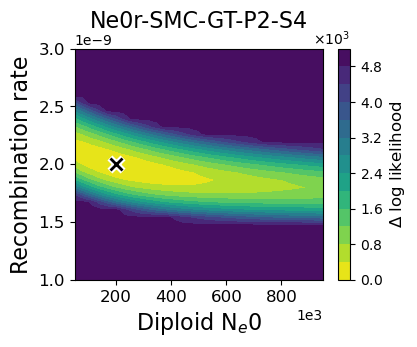

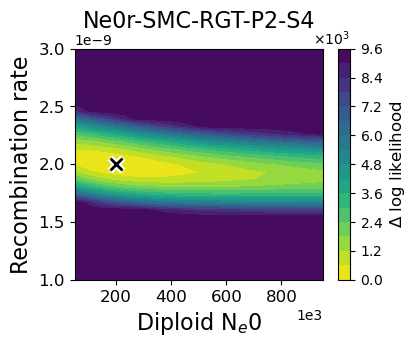

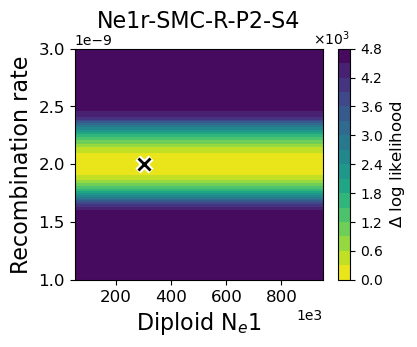

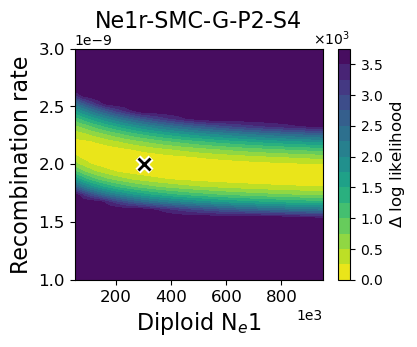

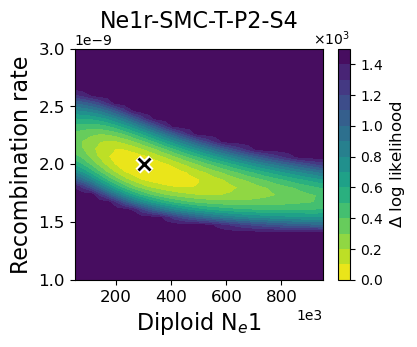

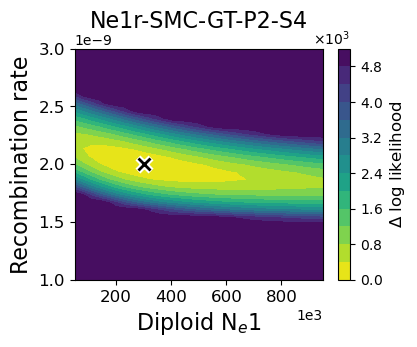

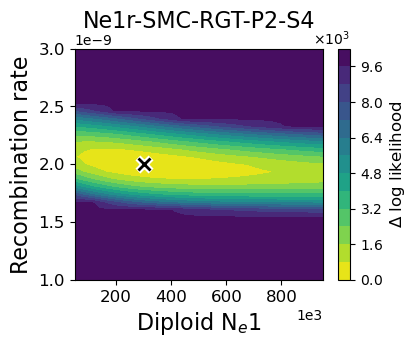

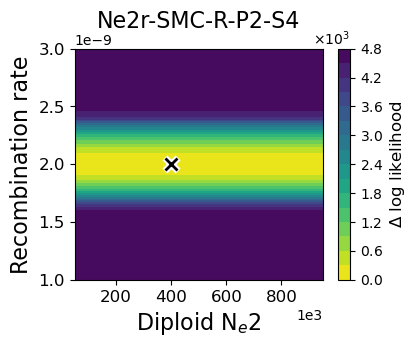

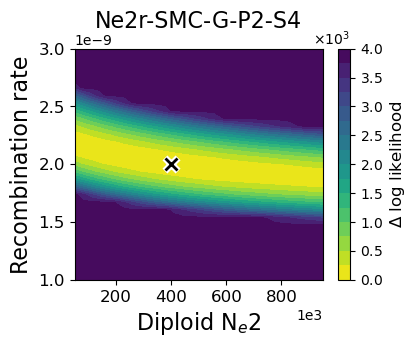

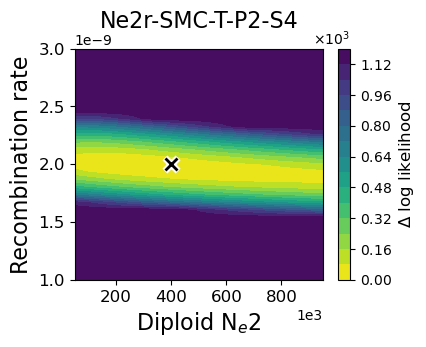

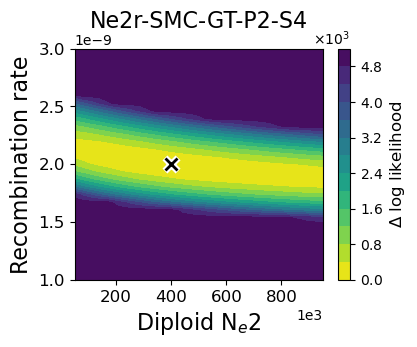

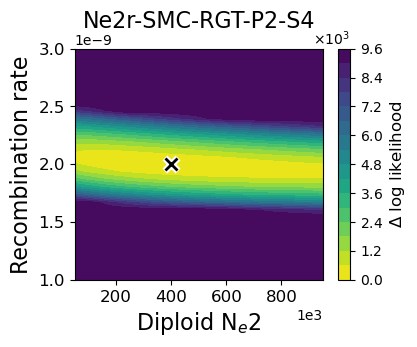

In [48]:
for nx in range(sptree.nnodes):

    title = f"Ne{nx}r-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'r')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'g')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 't')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}r-SMC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'rgt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### Plot combined MSC + SMC likelihood surface. 

Here we could weight the two likelihoods equally, as could be done for example using priors.

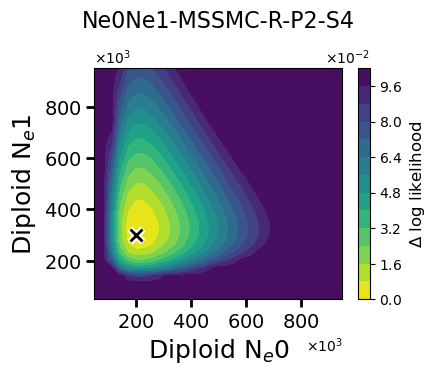

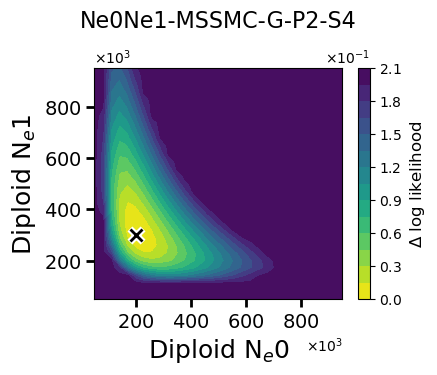

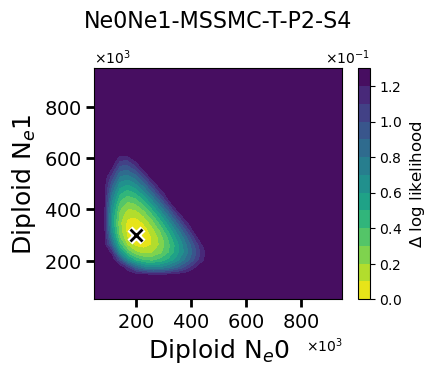

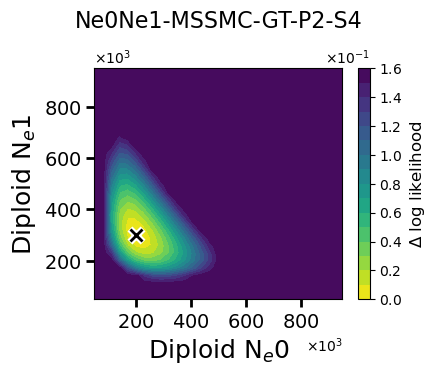

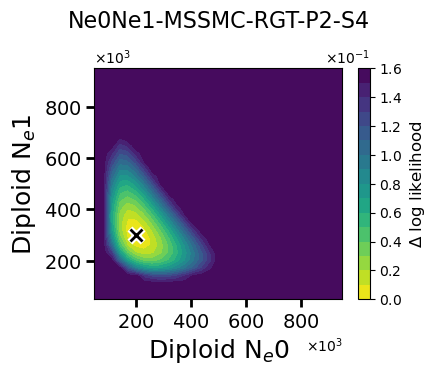

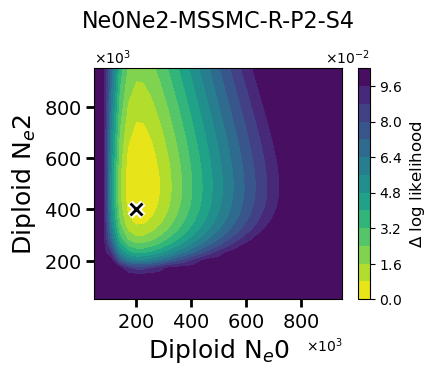

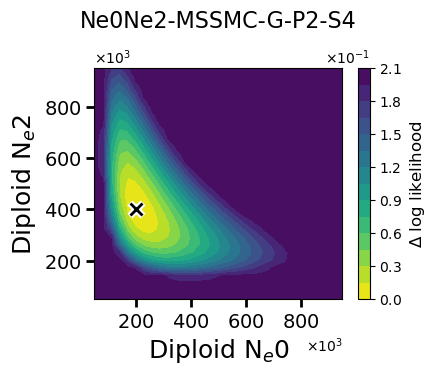

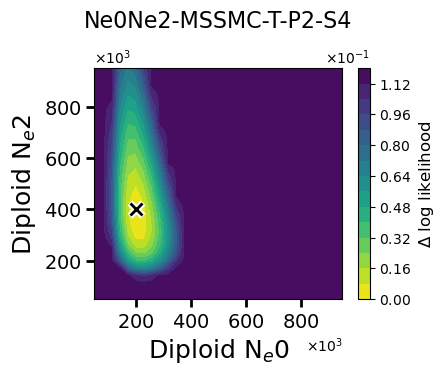

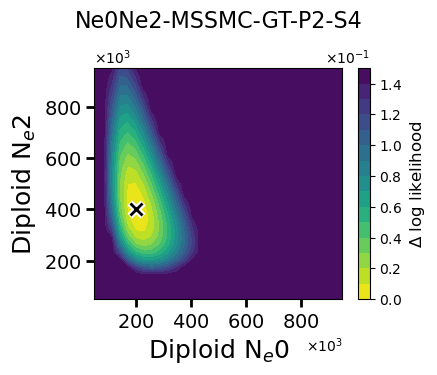

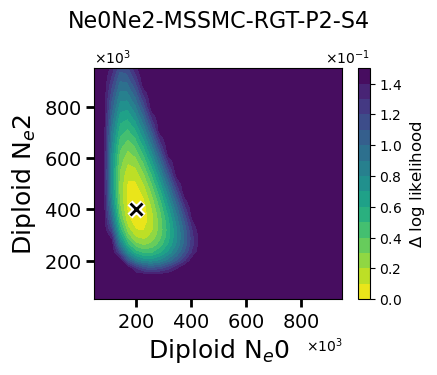

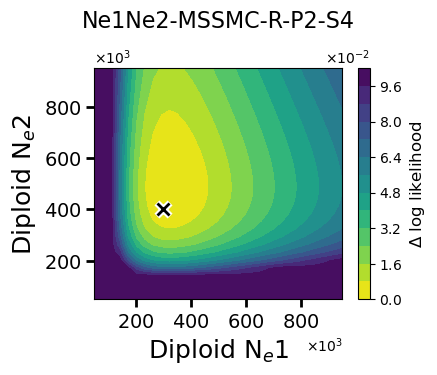

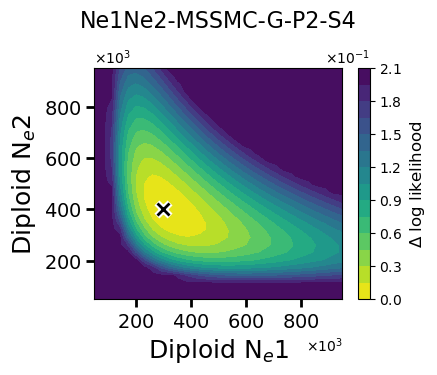

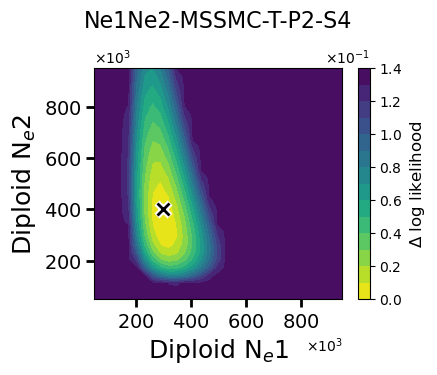

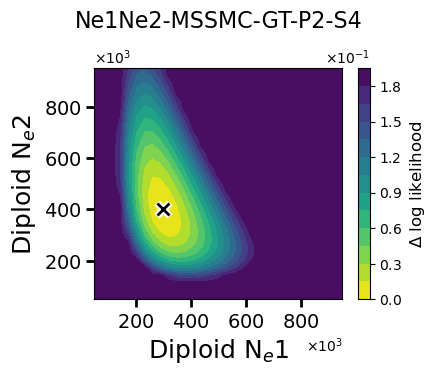

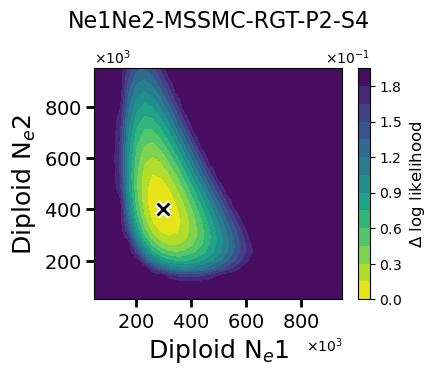

In [49]:
NORM = True

for nx, ny in [(0, 1), (0, 2), (1, 2)]:
    
    for e in ('r', 'g', 't', 'gt', 'rgt'):
        
        msc = MSC[(nx, ny, e)]
        smc = SMC[(nx, ny, e)]

        title = f"Ne{nx}Ne{ny}-MSSMC-{e.upper()}-P{NSPECIES}-S{NSAMPLES}"

        # combine msc and smc with *equal weighting*
        if NORM:
            msc_norm = 1 + (msc[2] - msc[2].min()) / (msc[2].max() - msc[2].min())
            if e == 'r':
                smc_norm = np.ones(msc_norm.shape)
            else:
                smc_norm = 1 + (smc[2] - smc[2].min()) / (smc[2].max() - smc[2].min())
            val = (msc_norm + smc_norm)
        else:
            val = msc[2] + smc[2]
        
        # plot likelihood surface
        c, a, x = plot_likelihood_surface_Nx_Ny(msc[0], msc[1], val, nidx=nx, nidy=ny, title=title)
        x[2].formatter.set_powerlimits((0, 0))
        c.savefig((DIR / title).with_suffix('.svg'))

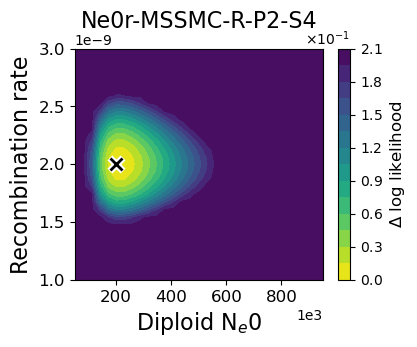

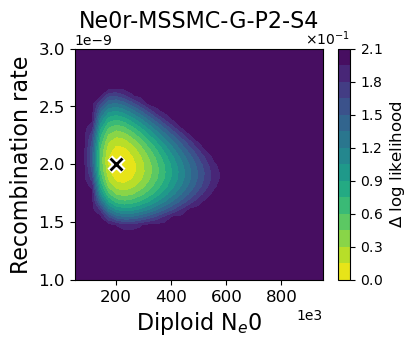

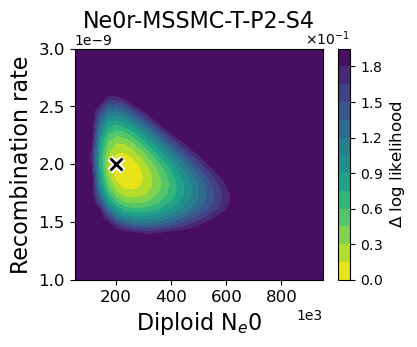

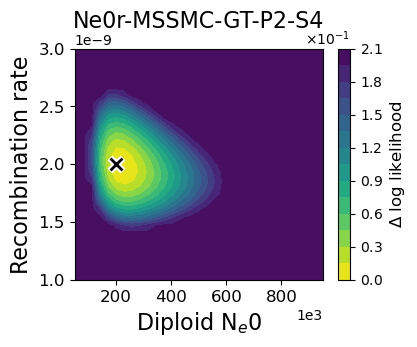

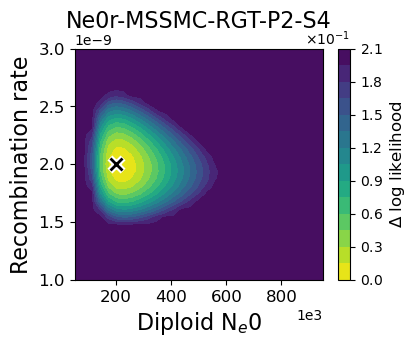

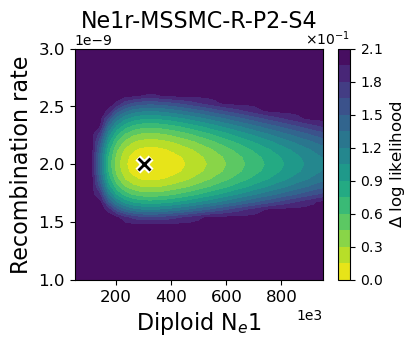

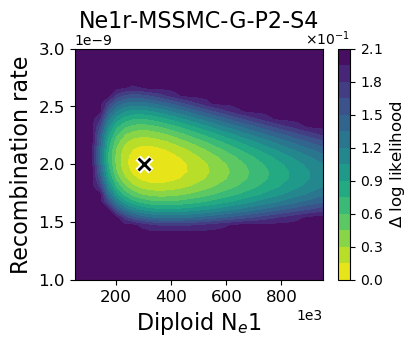

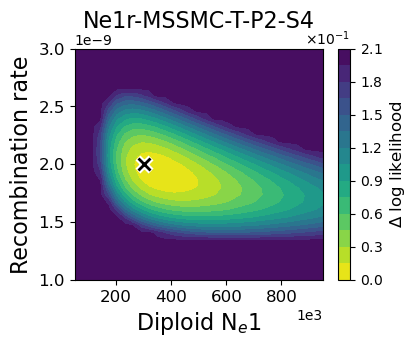

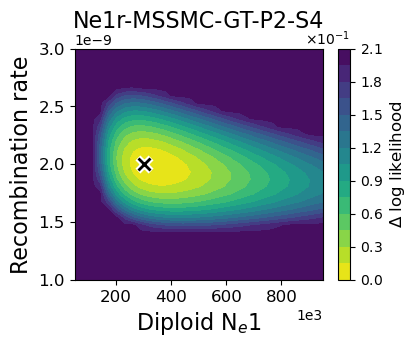

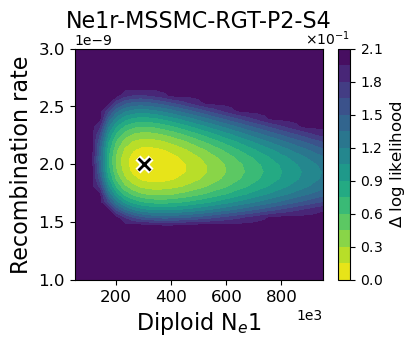

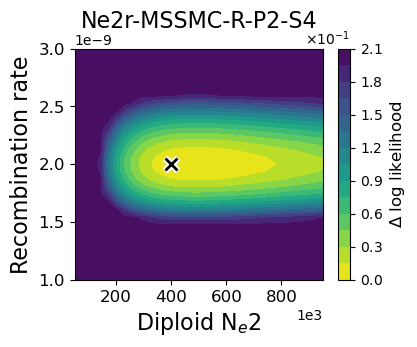

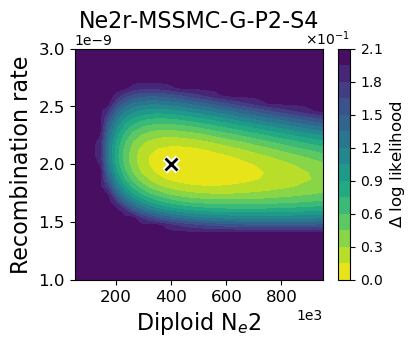

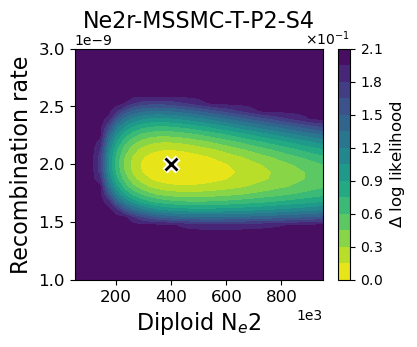

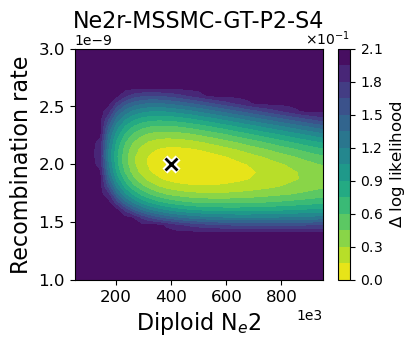

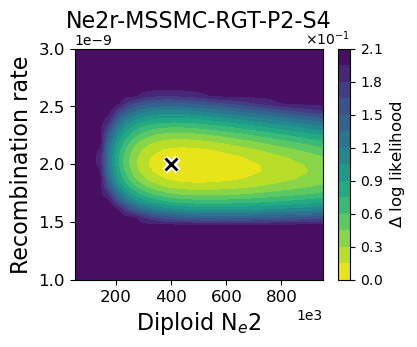

In [50]:
NORM = True
for nx in range(sptree.nnodes):
    
    for e in ('r', 'g', 't', 'gt', 'rgt'):
        
        msc = MSC[(nx, 'r', e)]
        smc = SMC[(nx, 'r', e)]

        title = f"Ne{nx}r-MSSMC-{e.upper()}-P{NSPECIES}-S{NSAMPLES}"
        #c, _, _ = plot_likelihood_surface_r_Nx(msc[0], msc[1], msc[2] + smc[2], nidx=nx, title=title);

        # combine msc and smc with equal weighting 
        if NORM:
            msc_norm = 1 + (msc[2] - msc[2].min()) / (msc[2].max() - msc[2].min())
            smc_norm = 1 + (smc[2] - smc[2].min()) / (smc[2].max() - smc[2].min())
            val = (msc_norm + smc_norm)
        else:
            val = msc[2] + smc[2]
        
        c, a, x = plot_likelihood_surface_r_Nx(msc[0], msc[1], val, nidx=nx, title=title);
        x[2].formatter.set_powerlimits((0, 0))
        c.savefig((DIR / title).with_suffix('.svg'))

### BAD PARAMETERIZATION
To further show that validity of our model, we also show how the likelihood surface will be incorrect if the species tree is incorrectly parameterized. In other words, when the data are generated under one model (the one shown above), but the likelihood is calculated under the assumption of a different demographic model. This shows that the MS-SMC can also be used for model selection. See our MCMC implementation from the paper as well to jointly infer parameters. 

In [51]:
MSC_BAD = {}
SMC_BAD = {}

In [52]:
# create a ToyTree of a single population w/ Ne=1e5
single_pop = toytree.tree("p[&&Ne=1e5];")
single_pop.get_node_data()

,idx,name,height,dist,support,Ne
0,0,p,0.0,0.0,NaN,100000.0


In [53]:
# create imap assigning all tips to a single pop (p)
single_pop_imap = {"p": imap["r0"] + imap["r1"]}
single_pop_imap

{'p': ['r0_0', 'r0_1', 'r0_2', 'r0_3', 'r1_0', 'r1_1', 'r1_2', 'r1_3']}

In [54]:
# create Embeddings for each collection of trees into the single pop model
Rbad = ipcoal.smc.TreeEmbedding(single_pop, trees_r, single_pop_imap, nproc=20)
Gbad = ipcoal.smc.TreeEmbedding(single_pop, trees_g, single_pop_imap, nproc=20)
Tbad = ipcoal.smc.TreeEmbedding(single_pop, trees_t, single_pop_imap, nproc=20)

In [55]:
for nx in [0]:

    SMC_r_R = get_smc_likelihood_surface_Nx_r(
        Rbad,
        dists_r,
        event_type=0,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    SMC_r_G = get_smc_likelihood_surface_Nx_r(
        Gbad,
        dists_g,
        event_type=1,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )

    SMC_r_T = get_smc_likelihood_surface_Nx_r(
        Tbad,
        dists_t,
        event_type=2,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
        n_values=N_VALUES,
    )
    
    # store for later
    SMC_BAD[(nx, 'r', 'r')] = SMC_r_R
    SMC_BAD[(nx, 'r', 'g')] = SMC_r_G
    SMC_BAD[(nx, 'r', 't')] = SMC_r_T
    SMC_BAD[(nx, 'r', 'gt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_G[2] + SMC_r_T[2]
    SMC_BAD[(nx, 'r', 'rgt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_R[2] + SMC_r_G[2] + SMC_r_T[2]

This shows that recombination event data (R) provides no information for distinguishing between demographic models, but can yield a correct recombination rate estimate if such intervals can be identified accurately (which is hard, because they're often invisible). By contrast, recombination events causing a tree-change (G) provide some information for distinguishing between demographic models, since we can see that inference using the wrong model here leads to an inaccurate likelihood surface. However, these interval lengths are also often difficult to delimit since coalescent time changes alone provide little signal. Finally, topology-change events (T) provide the most information for distinguishing between demographic models. These intervals are also the easiest to identify and delimit. We can see that trees and interval lengths delimited by topology-changes clearly shows that this model is a poor fit to the data.

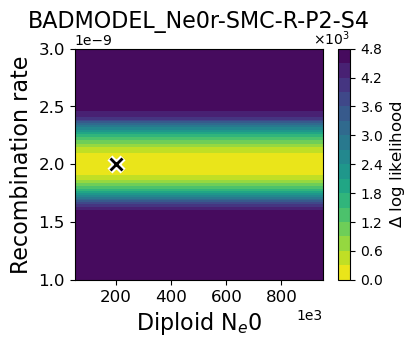

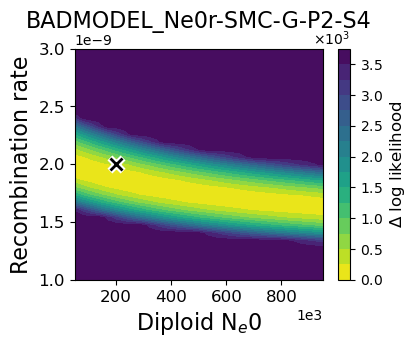

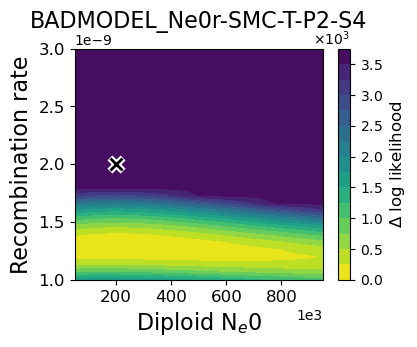

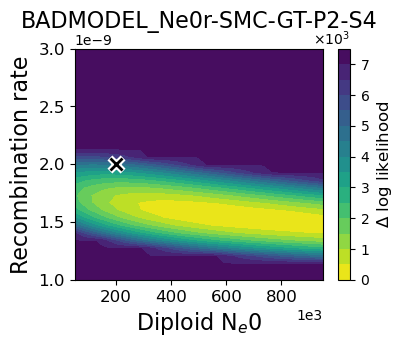

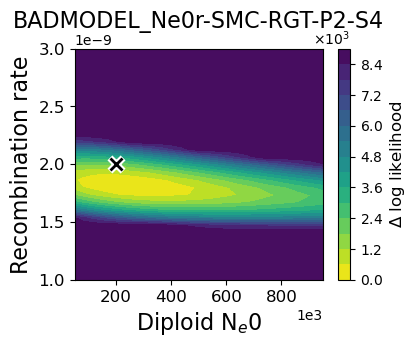

In [56]:
for nx in [0]:

    title = f"BADMODEL_Ne{nx}r-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_BAD[(nx, 'r', 'r')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"BADMODEL_Ne{nx}r-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_BAD[(nx, 'r', 'g')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"BADMODEL_Ne{nx}r-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_BAD[(nx, 'r', 't')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"BADMODEL_Ne{nx}r-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_BAD[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"BADMODEL_Ne{nx}r-SMC-RGT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_BAD[(nx, 'r', 'rgt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))